# Character Language Modelling with LSTM

In [76]:
import sys
import io
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, LSTM
from keras.layers.embeddings import Embedding
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [77]:
# raw_text = open("data/wonderland.txt", "r", encoding="utf-8").read()
# raw_text = raw_text.lower()
# print raw_text[:200]
# import io
# with io.open("my_utf8_file.txt", "r", encoding="utf-8") as my_file:
#      my_unicode_string = my_file.read() 
with io.open("data/wonderland.txt", "r", encoding="utf-8") as my_file:
     raw_text = my_file.read()      

In [78]:
raw_text = raw_text.lower()
print raw_text[:200]

chapter i. down the rabbit-hole

alice was beginning to get very tired of sitting by her sister on the
bank, and of having nothing to do: once or twice she had peeped into the
book her sister was read


In [79]:
chars = sorted(list(set(raw_text)))
n_chars = len(raw_text)
n_vocab = len(chars)
print "Total Characters:", n_chars
print "Total Vocab:", n_vocab
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

Total Characters: 144348
Total Vocab: 45


In [80]:
from nltk import tokenize
sentences = tokenize.sent_tokenize(raw_text)
lengths = []
for i in xrange(len(sentences)):
    lengths.append(len(sentences[i]))
lengths = np.array(lengths)
sentences[0]

u'chapter i. down the rabbit-hole\n\nalice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into the\nbook her sister was reading, but it had no pictures or conversations in\nit, \u2018and what is the use of a book,\u2019 thought alice \u2018without pictures or\nconversations?\u2019\n\nso she was considering in her own mind (as well as she could, for the\nhot day made her feel very sleepy and stupid), whether the pleasure\nof making a daisy-chain would be worth the trouble of getting up and\npicking the daisies, when suddenly a white rabbit with pink eyes ran\nclose by her.'

In [81]:
seq_length = 100
dataX = []
dataY = []
for i in xrange(0, n_chars - seq_length):
    seq_in  = raw_text[i: i+seq_length]
    seq_out = raw_text[i+seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print 'Total patterns:', n_patterns

Total patterns: 144248


In [82]:
# Reshape dataX to size of [samples, time steps, features] and scale it to 0-1
# Represent dataY as one hot encoding
X_train = np.reshape(dataX, (n_patterns, seq_length, 1))/float(n_vocab)
Y_train = np_utils.to_categorical(dataY)

# Small LSTM Network with Constant Characters

In [83]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(Y_train.shape[1], activation='softmax'))
# model.compile(loss='binary_crossentropy', optimizer=model_optimizer, metrics=['accuracy', 'cosine'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 45)                11565     
Total params: 275,757
Trainable params: 275,757
Non-trainable params: 0
_________________________________________________________________
None


# Small constant characters with embedding vector in LSTM Network

In [100]:
embedding_vector_length = 32
model1 = Sequential()
model1.add(Embedding(n_vocab, embedding_vector_length, input_length=seq_length))
model1.add(LSTM(256))
model1.add(Dropout(0.2))
model1.add(Dense(Y_train.shape[1], activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam')
print model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           1440      
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 45)                11565     
Total params: 308,941
Trainable params: 308,941
Non-trainable params: 0
_________________________________________________________________
None


# Add more LSTM Network layer with constant characters

In [101]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64))
model2.add(Dropout(0.2))
model2.add(Dense(Y_train.shape[1], activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam')
print model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 256)          264192    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 45)                2925      
Total params: 349,293
Trainable params: 349,293
Non-trainable params: 0
_________________________________________________________________
None


In [84]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [85]:
model_info = model.fit(X_train, Y_train, epochs=20, batch_size=64, callbacks=callbacks_list)

Epoch 1/20
144248/144248 [==============================] - 342s - loss: 2.9343 - acc: 0.2000   
Epoch 2/20
144248/144248 [==============================] - 342s - loss: 2.7035 - acc: 0.2525   
Epoch 3/20
144248/144248 [==============================] - 342s - loss: 2.5986 - acc: 0.2720   
Epoch 4/20
144248/144248 [==============================] - 342s - loss: 2.5177 - acc: 0.2918   
Epoch 5/20
144248/144248 [==============================] - 342s - loss: 2.4406 - acc: 0.3110   
Epoch 6/20
144248/144248 [==============================] - 342s - loss: 2.3701 - acc: 0.3279   
Epoch 7/20
144248/144248 [==============================] - 342s - loss: 2.3065 - acc: 0.3429   
Epoch 8/20
144248/144248 [==============================] - 342s - loss: 2.2489 - acc: 0.3584   
Epoch 9/20
144248/144248 [==============================] - 342s - loss: 2.1943 - acc: 0.3706   
Epoch 10/20
144248/144248 [==============================] - 342s - loss: 2.1472 - acc: 0.3831   
Epoch 11/20
144248/144248 [==

In [93]:
import matplotlib.pyplot as plt
print('Printing the model graph.....')
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[0].set_title('Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    plt.savefig('accuracy1.png')
        
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].set_title('Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.savefig('loss1.png')     
    plt.show()

Printing the model graph.....


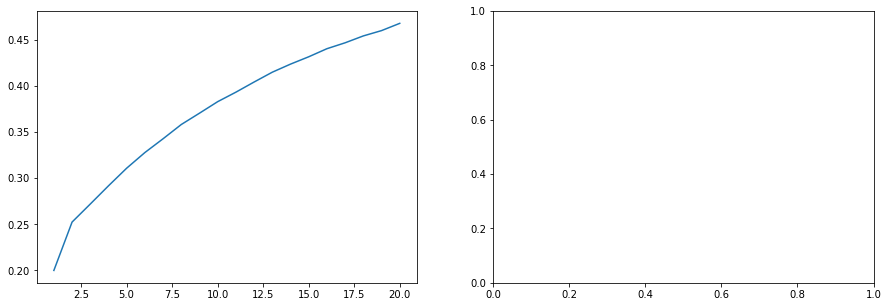

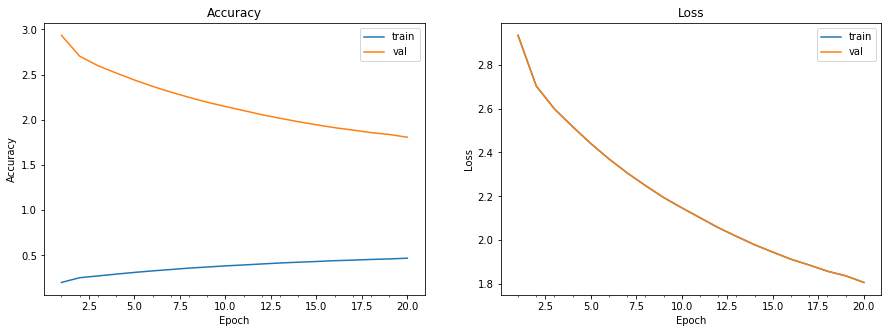

In [94]:
plot_model_history(model_info)

In [96]:
# load the network weights
filename = "weights-improvement-19-1.8070.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [98]:
start = np.random.randint(0, len(X_train)-1)
pattern = dataX[start]
print "Seed:"
print "\"", ''.join([int_to_char[value] for value in pattern]), "\""
print "\nGenerated Sequence:\n"
for i in xrange(200):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x/float(n_vocab)
    prediction = model.predict(x)
    index = np.argmax(prediction)
    result = int_to_char[index]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print "\nDone."

Seed:
" ll very slowly, for she had
plenty of time as she went down to look about her and to wonder what was "

Generated Sequence:

 a little saati, and the white rabbit were tiitg the was soin in aade a tirt eerd  at the was sore firter to the thees shat see was soin in a torele to the theee an she was aoiie the sabbit hare no en
Done.
